In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font',family='Times New Roman')
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
#import winsound
import pickle
import glob
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
#dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = '/home/olivia/mothPruning/mothMachineLearning_dataAndFigs/Figs/'
dataOutput = '/home/olivia/mothPruning/mothMachineLearning_dataAndFigs/DataOutput/'
savedModels = '/home/olivia/mothPruning/mothMachineLearning_dataAndFigs/savedModels/'
dataDir = '/home/olivia/mothPruning/mothMachineLearning_dataAndFigs/PythonGeneratedData_oneTorque/'

if not os.path.exists(figDir):
    os.mkdir(figDir)

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0] 

last run on 2022-01-04 11:28:13.476176


In [2]:
tf.__version__

'2.0.0'

In [3]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Make training and test set

In [5]:
# get table names in database
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
cursorObj = con1.cursor()
res = cursorObj.execute("SELECT name FROM sqlite_master WHERE type='table';")
tableNames = [name[0] for name in res]
con1.close()
print(tableNames)

['test', 'train']


In [6]:
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
trainDF = pd.read_sql_query("SELECT * FROM train", con1)
testDF = pd.read_sql_query("SELECT * FROM test", con1)
con1.close()

In [7]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

0

In [8]:
print(trainDF.shape)
trainDF.head()

(10000000, 19)


,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau0
0,0.0,1127.569064,0.0,765.895323,1.075898,11.962440,3.427385,18.462602,18.323331,716.627905,14.965420,553.784155,2.653195,147.068401,5.115222,153.187791,41181.992912,1.987846,-63216.237665
1,0.0,979.651081,0.0,-625.561275,0.306688,-5.637037,2.576453,19.788635,18.603118,878.261004,-13.758388,-732.267264,0.102441,-34.254744,2.372751,-34.214230,9062.020340,3.567122,19108.940596
2,0.0,1111.257777,0.0,-1406.672066,5.094943,16.102668,1.775724,-9.188076,19.014000,1058.629029,-25.108839,-1007.321715,2.811424,-218.672246,-0.370204,-211.787743,42727.993224,4.104033,49781.327507
3,0.0,-1438.730397,0.0,690.882986,5.034187,-3.375327,5.534301,-9.669100,-31.101504,-1501.738112,10.625933,331.290367,6.319507,141.205184,6.795796,140.443097,28953.145279,4.698031,92261.347215
4,0.0,1370.322727,0.0,-216.459775,4.186927,-16.500337,3.194818,-0.385905,27.276171,1358.779274,-4.544002,-238.613391,3.984840,-10.035763,3.181642,-0.756667,371.601599,0.668810,-40259.257246


In [9]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

# rename columns to be consistent with other code
testDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [10]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

testDF["Fx"] = testDF.F * np.cos(testDF.alpha)
testDF["Fy"] = testDF.F * np.sin(testDF.alpha)


In [11]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

# make test dataset
Xtest = testDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Ytest = testDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [12]:
X.head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,3.427385,1.075898,18.323331,14.965420,5.115222,2.653195,1127.569064,765.895323,18.462602,11.962440
1,2.576453,0.306688,18.603118,-13.758388,2.372751,0.102441,979.651081,-625.561275,19.788635,-5.637037
2,1.775724,5.094943,19.014000,-25.108839,-0.370204,2.811424,1111.257777,-1406.672066,-9.188076,16.102668
3,5.534301,5.034187,-31.101504,10.625933,6.795796,6.319507,-1438.730397,690.882986,-9.669100,-3.375327
4,3.194818,4.186927,27.276171,-4.544002,3.181642,3.984840,1370.322727,-216.459775,-0.385905,-16.500337


In [13]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-16681.383440,37652.197635,-63216.237665,716.627905,553.784155,153.187791,147.068401
1,-8253.874132,-3740.825371,19108.940596,878.261004,-732.267264,-34.214230,-34.254744
2,-24419.876370,-35062.102662,49781.327507,1058.629029,-1007.321715,-211.787743,-218.672246
3,-415.702991,-28950.160838,92261.347215,-1501.738112,331.290367,140.443097,141.205184
4,291.543841,230.412537,-40259.257246,1358.779274,-238.613391,-0.756667,-10.035763


In [14]:
# val train split
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [15]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xval_scaled = scalerX.transform(Xval)
Yval_scaled = scalerY.transform(Yval)


# final test data
Xtest_scaled = scalerX.transform(Xtest)

In [16]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.440808,-0.497541,-0.376881,-0.092528,0.279106,-0.125546,-0.413733,-0.087276,0.151751,-0.419563
1,0.002656,0.450960,0.232234,0.301146,-0.030380,0.180345,0.276074,0.383212,0.227138,0.094672
2,0.302116,0.217276,0.364791,-0.175444,-0.008066,-0.047502,0.385703,-0.188919,-0.266187,-0.202705
3,-0.471247,0.121804,0.070077,0.310735,-0.319397,-0.062783,0.103501,0.332100,-0.227711,0.447327
4,-0.350056,-0.349031,0.313582,0.159721,-0.093290,-0.092005,0.350805,0.216431,0.136925,0.270457


# Keras models

In [17]:
# import
#from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
#from keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Keras callcacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

In [18]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [400, 16], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    #K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization),use_bias=True)(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh',use_bias=True)(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear',use_bias=True)(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [19]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

# Adjusting early stop from 0.000001 to 0.0001 to try to make my plot look more like Callin's 
earlystop = EarlyStopping(monitor='val_mse', patience=2, 
                          verbose=1, mode='auto', min_delta = 0.00001)

In [20]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [21]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history.history['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history.history['val_mean_squared_error']), 50), 50)
    axs.legend(['train', 'validation'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + ".pdf"), dpi = 500, bbox_inches='tight')
    


    
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(16,8))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'], '#2b2688')
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'], '#c4385a', alpha = 0.4)
    #axs.set_title('Learning curve for sequential pruning')
    #axs.set_ylabel('Mean squared error')
    #Callin's plot titles
    #'Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1]))
    #axs.set_xlabel('Epoch')
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.set_xticks(np.arange(0,len(model_history_dictionary['val_mean_squared_error']), 50),50)
    axs.legend(['train', 'validation'], loc=2, fontsize=14)
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))


___

### Model creation and compilation should happen within strategy 

In [22]:
tf.keras.backend.clear_session()

In [23]:
modelParams = {"optimizer": tf.keras.optimizers.Adam(learning_rate=5e-4),
"dropout_rate" : 0,
"numUnits": [400, 400, 400, 16],
"weightRegularization": 0
}

model = create_network(**modelParams)

modeltimestamp = datetime.now().strftime("%Y_%m_%d__%I_%M_%S")
modelName = ''.join('{}*{}__'.format(key[0:3].capitalize(), val) for key, val in modelParams.items()).\
replace("[", "").replace("]", "").replace(", ", "*")[0:-2] + "_" + modeltimestamp

modelSubdir = os.path.join(dataOutput, modeltimestamp)
if not os.path.exists(modelSubdir):
    os.mkdir(modelSubdir)

print(modelName)

model.summary()

Opt*<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc140863128>__Dro*0__Num*400*400*400*16__Wei*0_2022_01_04__11_32_01
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 400)               4400      
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 119  

In [24]:
# save scalers, to be used on test set

scalerSubdir = os.path.join(modelSubdir, 'scalers')
if not os.path.exists(scalerSubdir):
    os.mkdir(scalerSubdir)
    
scalerfileX = 'scalerX_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerX, open(os.path.join(scalerSubdir, scalerfileX), 'wb'))

scalerfileY = 'scalerY_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerY, open(os.path.join(scalerSubdir, scalerfileY), 'wb'))

In [25]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [26]:
import time
history = LossHistory()

In [27]:
start_time = time.time()

#Training with single GPU
model_history = model.fit(Xtrain_scaled, Ytrain_scaled,
    validation_data=(Xval_scaled, Yval_scaled),
    callbacks = [earlystop, history],
    verbose = 1, batch_size=128, epochs = 1000)

#Training with multiple GPUs
#history = model.fit(train_dataset,
#    validation_data=val_dataset,
#    callbacks = [earlystop],
#    verbose = 2, epochs = 1000)

print("--- %s seconds ---" % (time.time() - start_time))

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1000
8000000/8000000 [==============================] - 96s 12us/sample - loss: 0.0014 - mse: 0.0014 - val_loss: 3.1444e-04 - val_mse: 3.1444e-04
Epoch 2/1000
8000000/8000000 [==============================] - 96s 12us/sample - loss: 2.6649e-04 - mse: 2.6649e-04 - val_loss: 2.0257e-04 - val_mse: 2.0257e-04
Epoch 3/1000
8000000/8000000 [==============================] - 96s 12us/sample - loss: 2.1937e-04 - mse: 2.1937e-04 - val_loss: 1.7673e-04 - val_mse: 1.7673e-04
Epoch 4/1000
8000000/8000000 [==============================] - 98s 12us/sample - loss: 1.9575e-04 - mse: 1.9574e-04 - val_loss: 1.9448e-04 - val_mse: 1.9448e-04
Epoch 5/1000
8000000/8000000 [==============================] - 98s 12us/sample - loss: 1.8078e-04 - mse: 1.8079e-04 - val_loss: 1.5168e-04 - val_mse: 1.5168e-04
Epoch 6/1000
8000000/8000000 [==============================] - 98s 12us/sample - loss: 1.7067e-04 - mse: 1.7066e-04 - val_loss: 1.7773e-04 - va

In [28]:
# save history
historyDict["mean_squared_error"].extend(model_history.history['mse'])
historyDict["val_mean_squared_error"].extend(model_history.history['val_mse'])

/home/olivia/anaconda3/envs/deepLearn_V4/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


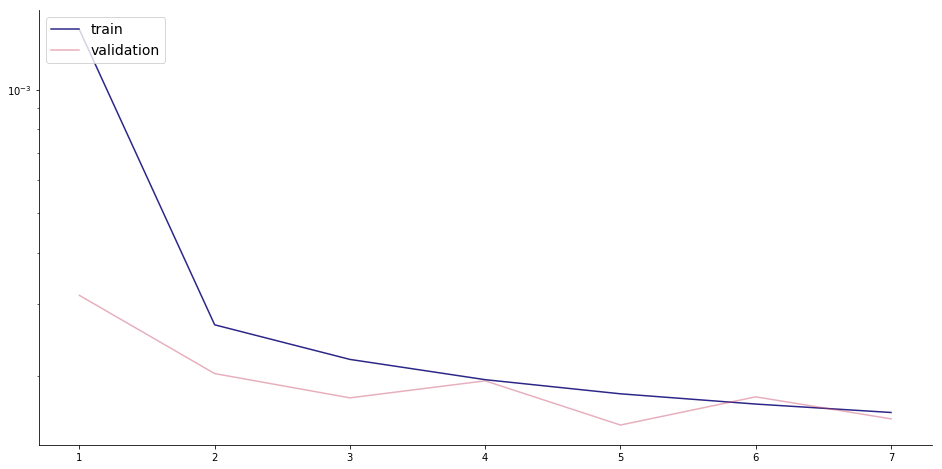

In [29]:
plot_model_history_fromDict(historyDict)
plt.show()

In [30]:
# save model
model.save(os.path.join(modelSubdir,  modelName + '.h5'))

#Original weights sub directory
weightsOGSubdir = os.path.join(modelSubdir, 'originalWeights')
if not os.path.exists(weightsOGSubdir):
    os.mkdir(weightsOGSubdir)

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(weightsOGSubdir, wtsFile), 'wb'))

# save history with same name as model
historyFile = modeltimestamp + '_original_history.pkl'
pickle.dump(historyDict, open(os.path.join(modelSubdir, historyFile), 'wb'))

#save batch history for plotting
batchhistoryFile = modeltimestamp + '_original_batch_history.pkl'
pickle.dump(history.losses, open(os.path.join(modelSubdir, batchhistoryFile), 'wb'))

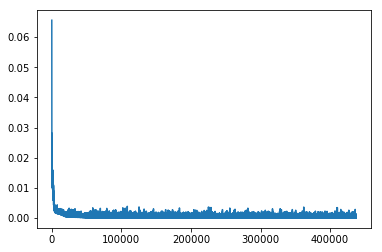

In [31]:
plt.plot(history.losses)

--------------------------------------------------------------------------------------------------------------

# Pruning with Tensorflow Model Optimization Toolkit

## Prune fixed amount of initial model
(rather than the sequential pruning)

In [38]:
from tensorflow.keras.models import load_model

import tensorflow_model_optimization as tfmot

import tempfile
import os

In [39]:
modelName

'Opt*<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc140863128>__Dro*0__Num*400*400*400*16__Wei*0_2022_01_04__11_32_01'

In [40]:
modelName = 'Opt*<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc140863128>__Dro*0__Num*400*400*400*16__Wei*0_2022_01_04__11_32_01'
modeltimestamp = "2022_01_04__11_32_01"
model = load_model(os.path.join(modelSubdir,  modelName + ".h5"))

# load history with same name as model
historyFile = modeltimestamp + '_original_history.pkl'
historyDict = pickle.load(open(os.path.join(modelSubdir, historyFile), 'rb'))

batchhistoryFile = modeltimestamp + '_original_batch_history.pkl'
batchHist = pickle.load(open(os.path.join(modelSubdir, batchhistoryFile), 'rb'))

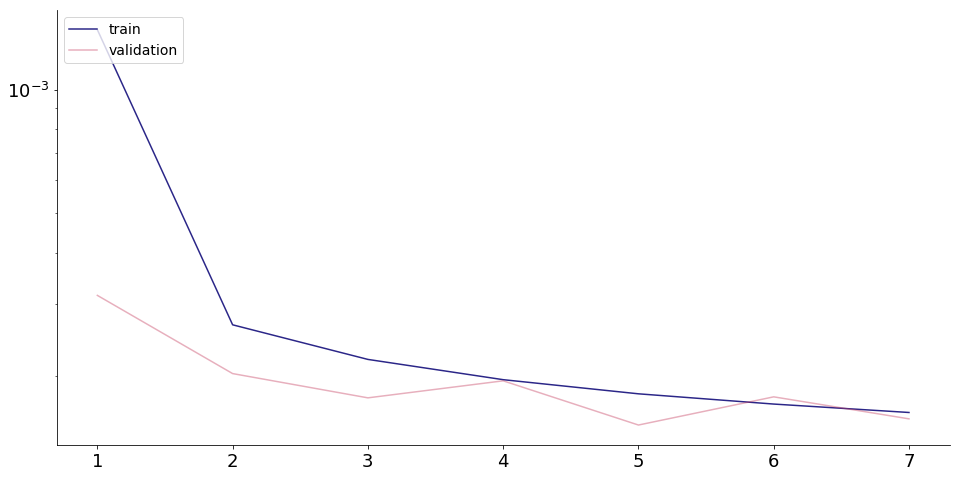

In [41]:
plot_model_history_fromDict(historyDict)
plt.show()

In [42]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
ConstantSparsity = tfmot.sparsity.keras.ConstantSparsity

### Define pruning parameters 

In [43]:
def define_pruning_params(percent_pruned):
    '''
    '''
    
    pruning_params = {
        'pruning_schedule': ConstantSparsity(percent_pruned,0),
        'block_size': (1,1),
        'block_pooling_type': 'AVG'
    }
    
    return(pruning_params)

### Create model for pruning

In [44]:
def create_pruned_model(model, 
                        pruning_params,
                        optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)):

    '''
    '''
    
    pruned_model = prune_low_magnitude(model, **pruning_params)
    
    pruned_model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])
    
    return(pruned_model)

In [45]:
logdir = tempfile.mkdtemp()
history = LossHistory()

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir = logdir),
    earlystop,
    history

]

In [46]:
pruning_params = define_pruning_params(0.85)
pruned_model = create_pruned_model(model, pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [47]:
pruned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 400)               8402      
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 400)               320402    
_________________________________________________________________
prune_low_magnitude_dense_2  (None, 400)               320402    
_________________________________________________________________
prune_low_magnitude_dense_3  (None, 16)                12818     
_________________________________________________________________
prune_low_magnitude_dense_4  (None, 7)                 233       
Total params: 662,257
Trainable params: 331,735
Non-trainable params: 330,522
_________________________________________________

In [48]:
start_time = time.time()


pruned_history = pruned_model.fit(Xtrain_scaled, Ytrain_scaled, 
                                  validation_data=(Xval_scaled, Yval_scaled),
                                  callbacks = callbacks,
                                  verbose = 2, batch_size=128, epochs = 1000)


print("--- %s seconds ---" % (time.time() - start_time))

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1000
8000000/8000000 - 190s - loss: 4.2183e-04 - mse: 4.2184e-04 - val_loss: 1.7301e-04 - val_mse: 1.7301e-04
Epoch 2/1000
8000000/8000000 - 190s - loss: 1.5907e-04 - mse: 1.5907e-04 - val_loss: 1.4557e-04 - val_mse: 1.4557e-04
Epoch 3/1000
8000000/8000000 - 190s - loss: 1.4465e-04 - mse: 1.4465e-04 - val_loss: 1.4765e-04 - val_mse: 1.4765e-04
Epoch 4/1000
8000000/8000000 - 191s - loss: 1.3802e-04 - mse: 1.3802e-04 - val_loss: 1.3324e-04 - val_mse: 1.3324e-04
Epoch 5/1000
8000000/8000000 - 191s - loss: 1.3339e-04 - mse: 1.3339e-04 - val_loss: 1.2397e-04 - val_mse: 1.2397e-04
Epoch 6/1000
8000000/8000000 - 190s - loss: 1.2960e-04 - mse: 1.2960e-04 - val_loss: 1.3561e-04 - val_mse: 1.3561e-04
Epoch 00006: early stopping
--- 1143.373881816864 seconds ---


In [49]:
historyDict["mean_squared_error"].extend(pruned_history.history['mse'])
historyDict["val_mean_squared_error"].extend(pruned_history.history['val_mse'])

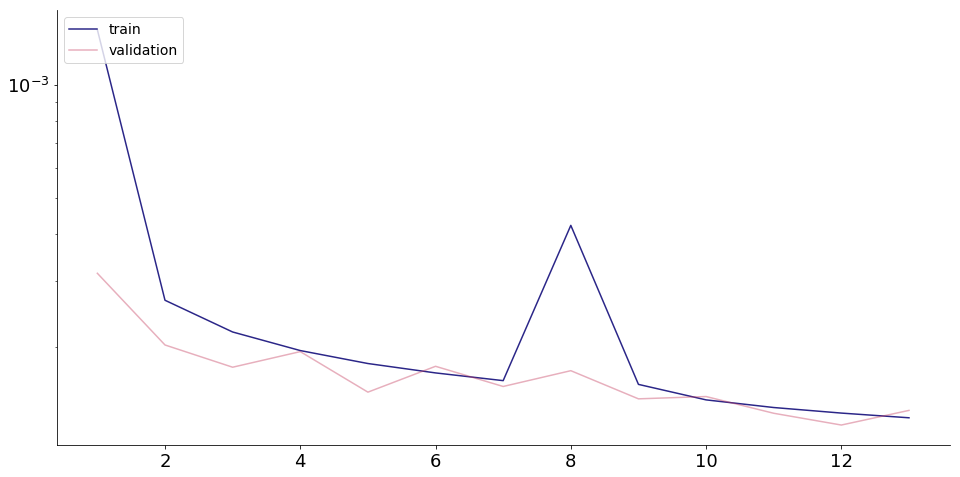

In [50]:
plot_model_history_fromDict(historyDict)
plt.show()

## Sequential pruning

In [51]:
from tensorflow.keras.models import load_model

import tensorflow_model_optimization as tfmot

import tempfile
import os

In [52]:
modelName

'Opt*<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc140863128>__Dro*0__Num*400*400*400*16__Wei*0_2022_01_04__11_32_01'

In [53]:
K.clear_session()

modelName = 'Opt*<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc140863128>__Dro*0__Num*400*400*400*16__Wei*0_2022_01_04__11_32_01'
modeltimestamp = "2022_01_04__11_32_01"
model = load_model(os.path.join(modelSubdir,  modelName + ".h5"))

# load history with same name as model
historyFile = modeltimestamp + '_original_history.pkl'
historyDict = pickle.load(open(os.path.join(modelSubdir, historyFile), 'rb'))

batchhistoryFile = modeltimestamp + '_original_batch_history.pkl'
batchHist = pickle.load(open(os.path.join(modelSubdir, batchhistoryFile), 'rb'))

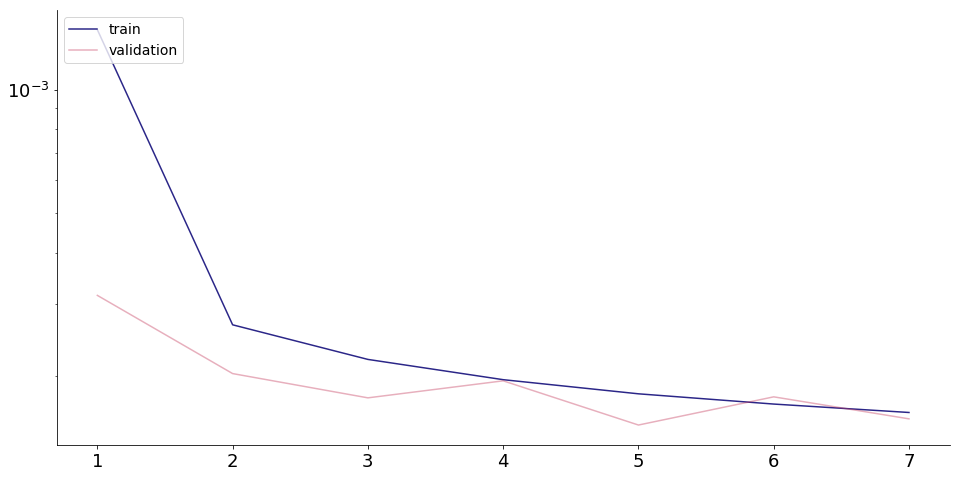

In [54]:
plot_model_history_fromDict(historyDict)
plt.show()

In [55]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
ConstantSparsity = tfmot.sparsity.keras.ConstantSparsity

In [56]:
cutPercent = [0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.90]
cutPercent = np.append(cutPercent, np.arange(0.91, 0.99, 0.01))
print(cutPercent)

[0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.9  0.91 0.92 0.93 0.94 0.95
 0.96 0.97 0.98]


In [57]:
# make new folder to save each prune
pruneSubdir = os.path.join(modelSubdir, 'prunes')
if not os.path.exists(pruneSubdir):
    os.mkdir(pruneSubdir)

In [58]:
def sequential_Pruning(model, cutPercent):
    '''
    '''
    
    for i in cutPercent:
        pruning_params = define_pruning_params(i)
        
        pruned_model = create_pruned_model(model, pruning_params)
        
        pruned_history = pruned_model.fit(Xtrain_scaled, Ytrain_scaled, 
                                  validation_data=(Xval_scaled, Yval_scaled),
                                  callbacks = callbacks,
                                  verbose = 1, batch_size=128, epochs = 500)
        
        historyDict["mean_squared_error"].extend(pruned_history.history['mse'])
        historyDict["val_mean_squared_error"].extend(pruned_history.history['val_mse'])
        batchHist.extend(history.losses)
        
        cut_epochs.append(len(pruned_history.history['mse']) + cut_epochs[-1])

        
        print("************************************** PRUNING", i*100, "% **********************************************")
        print("************************************** PRUNING", i*100, "% **********************************************")
        print("************************************** PRUNING", i*100, "% **********************************************")
        
        p_wts = pruned_model.get_weights()
        
        p_wts = np.array(p_wts)
        p_wts = p_wts.reshape(5,5)
        
        pruned_weights = []
        
        for j in range(len(p_wts)):
            pruned_weights.append(p_wts[j][0])
            pruned_weights.append(p_wts[j][1])
            
        model.set_weights(pruned_weights)
        
        # save model
        model.save(os.path.join(pruneSubdir, str(i) + '_pruned' + '.h5'))
        
    return cut_epochs

In [59]:
start_time = time.time()

#Keep track of which epochs a prune occurs
cut_epochs = [len(historyDict["mean_squared_error"])]

sequential_Pruning(model, cutPercent)

print("--- %s seconds ---" % (time.time() - start_time))

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 [==============================] - 200s 25us/sample - loss: 1.5820e-04 - mse: 1.5820e-04 - val_loss: 1.4820e-04 - val_mse: 1.4820e-04
Epoch 2/500
8000000/8000000 [==============================] - 198s 25us/sample - loss: 1.5128e-04 - mse: 1.5128e-04 - val_loss: 1.4883e-04 - val_mse: 1.4883e-04
Epoch 3/500
8000000/8000000 [==============================] - 194s 24us/sample - loss: 1.4689e-04 - mse: 1.4689e-04 - val_loss: 1.3504e-04 - val_mse: 1.3504e-04
Epoch 4/500
8000000/8000000 [==============================] - 193s 24us/sample - loss: 1.4313e-04 - mse: 1.4313e-04 - val_loss: 1.3527e-04 - val_mse: 1.3527e-04
Epoch 5/500
8000000/8000000 [==============================] - 191s 24us/sample - loss: 1.4000e-04 - mse: 1.4000e-04 - val_loss: 1.4834e-04 - val_mse: 1.4834e-04
Epoch 00005: early stopping
************************************** PRUNING 15.0 % **********************************************
*******

/home/olivia/anaconda3/envs/deepLearn_V4/lib/python3.6/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 [==============================] - 189s 24us/sample - loss: 1.3643e-04 - mse: 1.3643e-04 - val_loss: 1.2731e-04 - val_mse: 1.2731e-04
Epoch 2/500
8000000/8000000 [==============================] - 189s 24us/sample - loss: 1.3385e-04 - mse: 1.3385e-04 - val_loss: 1.2600e-04 - val_mse: 1.2600e-04
Epoch 3/500
8000000/8000000 [==============================] - 188s 23us/sample - loss: 1.3110e-04 - mse: 1.3110e-04 - val_loss: 1.2498e-04 - val_mse: 1.2498e-04
Epoch 00003: early stopping
************************************** PRUNING 25.0 % **********************************************
************************************** PRUNING 25.0 % **********************************************
************************************** PRUNING 25.0 % **********************************************
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 [==============================] - 188s 24us/sa

Epoch 2/500
8000000/8000000 [==============================] - 192s 24us/sample - loss: 1.4014e-04 - mse: 1.4014e-04 - val_loss: 1.4383e-04 - val_mse: 1.4383e-04
Epoch 3/500
8000000/8000000 [==============================] - 198s 25us/sample - loss: 1.3395e-04 - mse: 1.3395e-04 - val_loss: 1.3036e-04 - val_mse: 1.3036e-04
Epoch 4/500
8000000/8000000 [==============================] - 196s 24us/sample - loss: 1.3030e-04 - mse: 1.3030e-04 - val_loss: 1.2410e-04 - val_mse: 1.2410e-04
Epoch 5/500
8000000/8000000 [==============================] - 197s 25us/sample - loss: 1.2729e-04 - mse: 1.2729e-04 - val_loss: 1.3087e-04 - val_mse: 1.3087e-04
Epoch 00005: early stopping
************************************** PRUNING 91.0 % **********************************************
************************************** PRUNING 91.0 % **********************************************
************************************** PRUNING 91.0 % **********************************************
Train on 8000000 samp

Epoch 3/500
8000000/8000000 [==============================] - 195s 24us/sample - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 00003: early stopping
************************************** PRUNING 98.00000000000001 % **********************************************
************************************** PRUNING 98.00000000000001 % **********************************************
************************************** PRUNING 98.00000000000001 % **********************************************
--- 13840.402304410934 seconds ---


In [60]:
# save history with same name as model
historyFile = modeltimestamp + '_pruned_history.pkl'
pickle.dump(historyDict, open(os.path.join(modelSubdir, historyFile), 'wb'))

prune_timestamps = modeltimestamp + '_pune_timestamps'
pickle.dump(cut_epochs, open(os.path.join(modelSubdir, prune_timestamps), 'wb'))

batchhistoryFile = modeltimestamp + '_pruned_batch_history.pkl'
pickle.dump(batchHist, open(os.path.join(modelSubdir, batchhistoryFile), 'wb'))

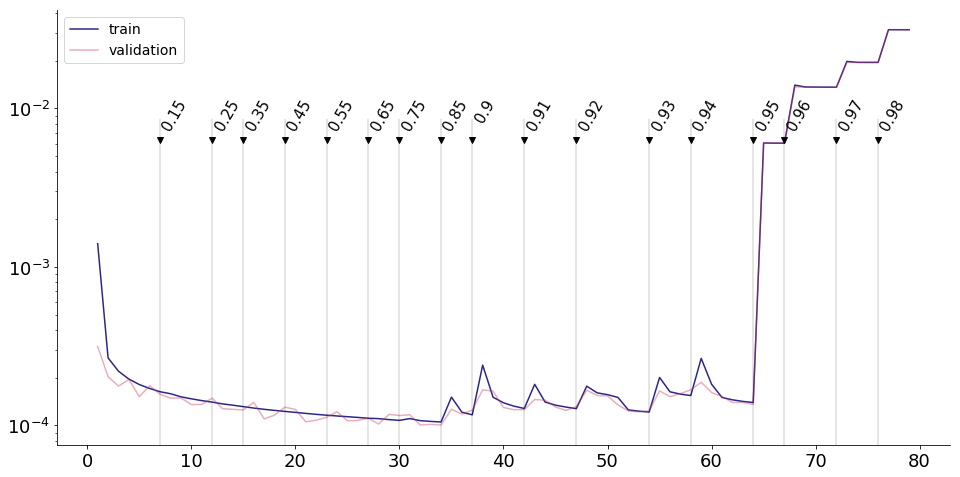

In [61]:
plot_model_history_fromDict(historyDict)

for i in range(len(cut_epochs)-1):
    plt.axvline(x=cut_epochs[i],ymax=0.75,color='k',linewidth=.2)
    plt.plot(cut_epochs[i],10**-2.2, "v", color = "black")
    
for i in range(0,len(cut_epochs)-1):
    plt.text(cut_epochs[i],0.01,round(cutPercent[i],4),rotation=60,fontsize='small')
    
plt.show()

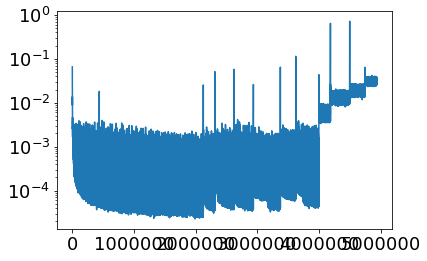

In [62]:
plt.plot(batchHist)
plt.yscale('log')

## Manual Pruning Algorithm

Load model, weights, and history

In [36]:
from tensorflow.keras.models import load_model

modelName =  'Opt*<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc140863128>__Dro*0__Num*400*400*400*16__Wei*0_2022_01_04__11_32_01'

modeltimestamp = "2022_01_04__11_32_01"
model = load_model(os.path.join(modelSubdir,  modelName + ".h5"))

wtsFile = modelName + '_wts.pkl'
wts = pickle.load(open(os.path.join(modelSubdir, 'originalWeights', wtsFile), 'rb'))

historyFile = modeltimestamp + '_original_history.pkl'
historyDict = pickle.load(open(os.path.join(modelSubdir, historyFile), 'rb'))


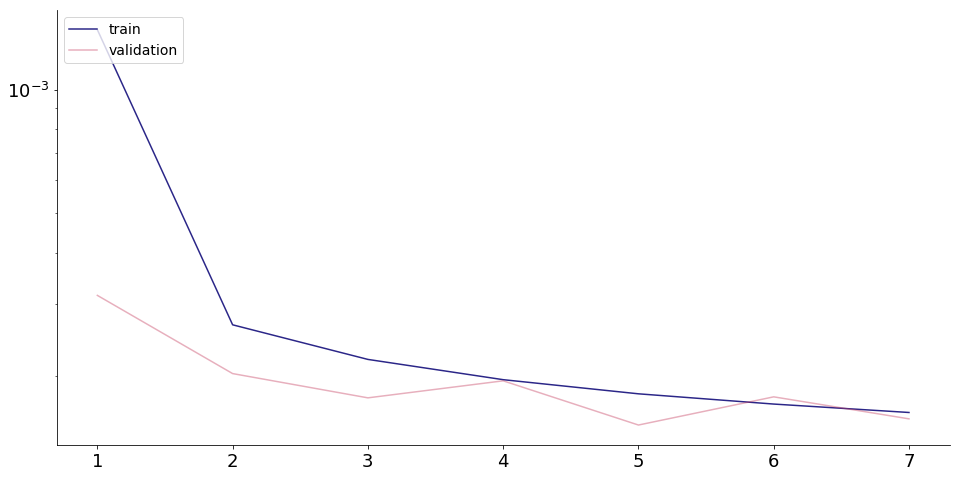

In [37]:
plt.rcParams.update({'font.size': 18})
plot_model_history_fromDict(historyDict)

plt.show()

In [21]:
# train with pruning
numCuts = 1

wts = model.get_weights()
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

In [22]:
# make new folder to save each prune
modelSubdir = os.path.join(savedModels, modeltimestamp + "_checkpointsCS_v2")
if not os.path.exists(modelSubdir):
    os.mkdir(modelSubdir)

In [100]:
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)

# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))

print(cutPercent)

[ 0.          7.93242521 15.47534606 22.31218051 28.24497764 33.20183851
 37.21384337 40.37844583 42.82424577 44.68488636 46.08342772 47.12515041
 47.8958653  48.46322944 48.87935937 49.18374288 49.40594778 49.56792665
 49.68587867 49.77170471 49.83411989 49.87949158 49.91246404 49.9364206
 49.95382384 49.96646499]


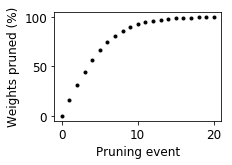

In [62]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=[3,2])
plt.plot((cutPercent*2)[0:21], ".", color = "black")
plt.xlabel("Pruning event")
plt.ylabel("Weights pruned (%)")
plt.savefig(os.path.join(figDir, "pruningPercentages.pdf"), bbox_inches='tight')

#### More natural pruning percentages: 

In [23]:
cutPercent = [0, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.90]
cutPercent = np.append(cutPercent, np.arange(0.91, 0.99, 0.01))
cutPercent = 100*cutPercent/2
print(cutPercent)

[ 0.   7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 45.  45.5 46.  46.5 47.
 47.5 48.  48.5 49. ]


cutPercent must be *100/2 (percentiles, not decimals) 

In [ ]:
overallEpochCounter = len(historyDict['mean_squared_error'])
print(overallEpochCounter)

firstPrune = True

while True:   
   
    for numEpocs in range(100):
        
        if firstPrune == True:
            MSE_tmp = []
            history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)       
            firstPrune = False
            
        else:
            MSE_tmp = []
            model = load_model(os.path.join(savedModels, modelSubdir, modelName + '_Pruned.h5'))
            history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)       
        
        overallEpochCounter += 1
        
        # save history
        historyDict["mean_squared_error"].extend(history.history["mse"])
        historyDict["val_mean_squared_error"].extend(history.history["val_mse"])
        
        # local MSE
        MSE_tmp.append(history.history["mse"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), 
                                    q = (50 - cutPercent[numCuts], 
                                        50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        model.save(os.path.join(savedModels,  modelSubdir, modelName + '_Pruned.h5'))
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.0001) or (history.history["mse"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                
                # save model
                #model.save(os.path.join(savedModels,  modelSubdir, modelName + '_Pruned.h5'))
                
            
                # save weights
                wts = model.get_weights().copy()

                wtsFile = str(overallEpochCounter) + "_" + modelName + '_wts.pkl'
                pickle.dump(wts, open(os.path.join(savedModels, modelSubdir, wtsFile), 'wb'))

                
                # save history with same name as model
                historyFile = modeltimestamp + '_history.pkl'
                pickle.dump(historyDict, open(os.path.join(savedModels,modelSubdir, historyFile), 'wb'))
                
                numCuts += 1                
                break
                
            #else:
                # save model
                #model.save(os.path.join(savedModels,  modelSubdir, modelName + '_Pruned.h5'))


    if numCuts >= len(cutPercent):
        break


313
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.9965e-04 - mse: 3.9965e-04 - val_loss: 4.3540e-04 - val_mse: 4.3540e-04
281976 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.9937e-04 - mse: 3.9936e-04 - val_loss: 4.5003e-04 - val_mse: 4.5003e-04
281976 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 9s - loss: 3.9927e-04 - mse: 3.9927e-04 - val_loss: 5.3847e-04 - val_mse: 5.3847e-04
281976 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 9s - loss: 3.9892e-04 - mse: 3.9892e-04 - val_loss: 4.3276e-04 - val_mse: 4.3276e-04
281976 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 3.9880e-04 - mse: 3.9880e-04 - val_loss: 3.8055e-04 - val_mse: 3.8055e-04
281976 of 331735 weights retained
Train on 8000000 samples, validate on 

8000000/8000000 - 11s - loss: 3.8969e-04 - mse: 3.8969e-04 - val_loss: 3.7593e-04 - val_mse: 3.7593e-04
149282 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.8932e-04 - mse: 3.8932e-04 - val_loss: 4.1594e-04 - val_mse: 4.1594e-04
149282 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 3.8925e-04 - mse: 3.8925e-04 - val_loss: 4.1495e-04 - val_mse: 4.1495e-04
149282 of 331735 weights retained
change in log loss: -0.0007513523101809749
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.8902e-0

49764 of 331735 weights retained
change in log loss: -0.0032643318176271974
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.1274e-04 - mse: 4.1274e-04 - val_loss: 4.4415e-04 - val_mse: 4.4415e-04
49764 of 331735 weights retained
change in log loss: -0.0027791976928712714
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.1216e-04 - mse: 4.1217e-04 - val_loss: 4.3889e-04 - val_mse: 4.3889e-04
49764 of 331735 weights retained
change in log loss: -0.0025139808654788265
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.1068e-04 - mse: 4.1068e-04 - val_loss: 4.8786e-04 - val_mse: 4.8786e-04
49764 of 331735 weights retained
change in log loss: -0.0026743888854983133
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.1001e-04 - mse: 4.1001e-04 - val_loss: 3.1245e-04 - val_mse: 3.1245e-04
49764 of 331735 weights retained
change in log loss: -0.00269956

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 3.9385e-04 - mse: 3.9385e-04 - val_loss: 3.7167e-04 - val_mse: 3.7167e-04
49764 of 331735 weights retained
change in log loss: -0.0005661487579348146
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.9364e-04 - mse: 3.9364e-04 - val_loss: 2.8635e-04 - val_mse: 2.8635e-04
49764 of 331735 weights retained
change in log loss: -0.0003159523010256571
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.9254e-04 - mse: 3.9254e-04 - val_loss: 3.2010e-04 - val_mse: 3.2010e-04
49764 of 331735 weights retained
change in log loss: -0.0009586811065676049
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 3.9221e-04 - mse: 3.9221e-04 - val_loss: 4.3204e-04 - val_mse: 4.3204e-04
49764 of 331735 weights retained
change in log loss: -0.0012925624847415218
Train on 8000000 samples, validate on 2000000 samples
8000000/80

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6931e-04 - mse: 4.6931e-04 - val_loss: 3.2690e-04 - val_mse: 3.2690e-04
33176 of 331735 weights retained
change in log loss: -0.012646245956421165
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6609e-04 - mse: 4.6609e-04 - val_loss: 3.3523e-04 - val_mse: 3.3523e-04
33176 of 331735 weights retained
change in log loss: -0.01093335151672381
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6509e-04 - mse: 4.6509e-04 - val_loss: 3.4307e-04 - val_mse: 3.4307e-04
33176 of 331735 weights retained
change in log loss: -0.007781791687011985
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6250e-04 - mse: 4.6250e-04 - val_loss: 5.3246e-04 - val_mse: 5.3246e-04
33176 of 331735 weights retained
change in log loss: -0.005834007263183838
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000

29858 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.6863e-04 - mse: 6.6863e-04 - val_loss: 4.5033e-04 - val_mse: 4.5034e-04
29858 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.1899e-04 - mse: 6.1899e-04 - val_loss: 5.9250e-04 - val_mse: 5.9250e-04
29858 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.0048e-04 - mse: 6.0048e-04 - val_loss: 3.7463e-04 - val_mse: 3.7463e-04
29858 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.8695e-04 - mse: 5.8695e-04 - val_loss: 5.0465e-04 - val_mse: 5.0465e-04
29858 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 12s - loss: 5.7948e-04 - mse: 5.7948e-04 - val_loss: 4.0600e-04 - val_mse: 4.0600e-04
29858 of 331735 weights retained
Train on 800

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.0179e-04 - mse: 5.0179e-04 - val_loss: 4.5210e-04 - val_mse: 4.5210e-04
29858 of 331735 weights retained
change in log loss: -0.0015700340270997648
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.0216e-04 - mse: 5.0216e-04 - val_loss: 5.4054e-04 - val_mse: 5.4054e-04
29858 of 331735 weights retained
change in log loss: -0.0016821384429932529
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.0055e-04 - mse: 5.0055e-04 - val_loss: 4.0738e-04 - val_mse: 4.0738e-04
29858 of 331735 weights retained
change in log loss: -0.0028073787689211205
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.9903e-04 - mse: 4.9903e-04 - val_loss: 5.5921e-04 - val_mse: 5.5921e-04
29858 of 331735 weights retained
change in log loss: -0.002642297744751221
Train on 8000000 samples, validate on 2000000 samples
8000000/800

8000000/8000000 - 11s - loss: 4.6731e-04 - mse: 4.6731e-04 - val_loss: 4.7676e-04 - val_mse: 4.7676e-04
29858 of 331735 weights retained
change in log loss: -0.0016606330871583586
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6782e-04 - mse: 4.6782e-04 - val_loss: 3.6559e-04 - val_mse: 3.6559e-04
29858 of 331735 weights retained
change in log loss: -0.0013108730316164774
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6536e-04 - mse: 4.6536e-04 - val_loss: 4.3906e-04 - val_mse: 4.3906e-04
29858 of 331735 weights retained
change in log loss: -0.002041530609131037
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6504e-04 - mse: 4.6504e-04 - val_loss: 5.5711e-04 - val_mse: 5.5711e-04
29858 of 331735 weights retained
change in log loss: -0.0022235870361330123
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6386e-04 - mse: 4.6387e-04 - val_

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.5810e-04 - mse: 4.5810e-04 - val_loss: 3.8148e-04 - val_mse: 3.8148e-04
26542 of 331735 weights retained
change in log loss: -0.001113224029541282
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.5740e-04 - mse: 4.5740e-04 - val_loss: 3.1839e-04 - val_mse: 3.1839e-04
26542 of 331735 weights retained
change in log loss: -0.0011243820190433018
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.5588e-04 - mse: 4.5588e-04 - val_loss: 5.5657e-04 - val_mse: 5.5657e-04
26542 of 331735 weights retained
change in log loss: -0.0011247634887697755
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.5482e-04 - mse: 4.5482e-04 - val_loss: 4.9063e-04 - val_mse: 4.9063e-04
26542 of 331735 weights retained
change in log loss: -0.0015936374664310415
Train on 8000000 samples, validate on 2000000 samples
8000000/800

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.7884e-04 - mse: 5.7884e-04 - val_loss: 5.3039e-04 - val_mse: 5.3039e-04
23224 of 331735 weights retained
change in log loss: -0.005294466018676891
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.7531e-04 - mse: 5.7531e-04 - val_loss: 5.1993e-04 - val_mse: 5.1993e-04
23224 of 331735 weights retained
change in log loss: -0.005398464202880926
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.7235e-04 - mse: 5.7235e-04 - val_loss: 5.4074e-04 - val_mse: 5.4074e-04
23224 of 331735 weights retained
change in log loss: -0.005402612686157382
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 5.6872e-04 - mse: 5.6872e-04 - val_loss: 4.5777e-04 - val_mse: 4.5777e-04
23224 of 331735 weights retained
change in log loss: -0.005946683883667037
Train on 8000000 samples, validate on 2000000 samples
8000000/800000

8000000/8000000 - 10s - loss: 5.0948e-04 - mse: 5.0948e-04 - val_loss: 4.5280e-04 - val_mse: 4.5280e-04
23224 of 331735 weights retained
change in log loss: -0.001280593872070579
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 5.0651e-04 - mse: 5.0651e-04 - val_loss: 7.6382e-04 - val_mse: 7.6382e-04
23224 of 331735 weights retained
change in log loss: -0.002013158798218062
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.0695e-04 - mse: 5.0695e-04 - val_loss: 4.5821e-04 - val_mse: 4.5821e-04
23224 of 331735 weights retained
change in log loss: -0.0018794059753420855
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 5.0529e-04 - mse: 5.0529e-04 - val_loss: 3.7933e-04 - val_mse: 3.7933e-04
23224 of 331735 weights retained
change in log loss: -0.002348709106445579
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.0422e-04 - mse: 5.0422e-04 - val_lo

23224 of 331735 weights retained
change in log loss: -0.0011513233184817784
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.8265e-04 - mse: 4.8265e-04 - val_loss: 5.7395e-04 - val_mse: 5.7395e-04
23224 of 331735 weights retained
change in log loss: -0.0014035701751712315
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.8167e-04 - mse: 4.8167e-04 - val_loss: 4.4336e-04 - val_mse: 4.4336e-04
23224 of 331735 weights retained
change in log loss: -0.0018101215362551493
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.8234e-04 - mse: 4.8234e-04 - val_loss: 4.8760e-04 - val_mse: 4.8760e-04
23224 of 331735 weights retained
change in log loss: -0.0009604454040529342
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.8091e-04 - mse: 4.8091e-04 - val_loss: 4.2738e-04 - val_mse: 4.2738e-04
23224 of 331735 weights retained
change in log loss: -0.00081033

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6817e-04 - mse: 4.6817e-04 - val_loss: 5.4391e-04 - val_mse: 5.4391e-04
23224 of 331735 weights retained
change in log loss: -0.0006112575531008746
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6821e-04 - mse: 4.6820e-04 - val_loss: 3.8344e-04 - val_mse: 3.8344e-04
23224 of 331735 weights retained
change in log loss: -0.0006302356719972702
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6732e-04 - mse: 4.6732e-04 - val_loss: 4.0057e-04 - val_mse: 4.0057e-04
23224 of 331735 weights retained
change in log loss: -0.0012076854705811435
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6823e-04 - mse: 4.6823e-04 - val_loss: 3.7164e-04 - val_mse: 3.7164e-04
23224 of 331735 weights retained
change in log loss: -0.0007507324218751776
Train on 8000000 samples, validate on 2000000 samples
8000000/80

19908 of 331735 weights retained
change in log loss: -0.0007723331451415794
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6944e-04 - mse: 4.6944e-04 - val_loss: 4.8677e-04 - val_mse: 4.8677e-04
19908 of 331735 weights retained
change in log loss: -0.0008431434631348544
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6890e-04 - mse: 4.6890e-04 - val_loss: 3.7868e-04 - val_mse: 3.7867e-04
19908 of 331735 weights retained
change in log loss: -0.0007742404937746139
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6814e-04 - mse: 4.6814e-04 - val_loss: 4.0383e-04 - val_mse: 4.0383e-04
19908 of 331735 weights retained
change in log loss: -0.0009941101074220082
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6757e-04 - mse: 4.6757e-04 - val_loss: 5.2499e-04 - val_mse: 5.2499e-04
19908 of 331735 weights retained
change in log loss: -0.00092015

16590 of 331735 weights retained
change in log loss: -0.005749797821045122
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.6938e-04 - mse: 6.6938e-04 - val_loss: 4.8238e-04 - val_mse: 4.8238e-04
16590 of 331735 weights retained
change in log loss: -0.005189180374145841
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.6495e-04 - mse: 6.6495e-04 - val_loss: 4.9722e-04 - val_mse: 4.9722e-04
16590 of 331735 weights retained
change in log loss: -0.004685831069946578
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.5994e-04 - mse: 6.5994e-04 - val_loss: 5.3401e-04 - val_mse: 5.3401e-04
16590 of 331735 weights retained
change in log loss: -0.005378723144531472
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.5814e-04 - mse: 6.5814e-04 - val_loss: 5.0541e-04 - val_mse: 5.0541e-04
16590 of 331735 weights retained
change in log loss: -0.005352735519

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.2388e-04 - mse: 6.2388e-04 - val_loss: 4.6836e-04 - val_mse: 4.6837e-04
16590 of 331735 weights retained
change in log loss: -0.0012181758880616123
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.2246e-04 - mse: 6.2246e-04 - val_loss: 5.2750e-04 - val_mse: 5.2750e-04
16590 of 331735 weights retained
change in log loss: -0.0007829666137696423
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.2149e-04 - mse: 6.2149e-04 - val_loss: 5.6734e-04 - val_mse: 5.6734e-04
16590 of 331735 weights retained
change in log loss: -0.0013176441192628285
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.2116e-04 - mse: 6.2116e-04 - val_loss: 5.6883e-04 - val_mse: 5.6883e-04
16590 of 331735 weights retained
change in log loss: -0.0014010429382325107
Train on 8000000 samples, validate on 2000000 samples
8000000/80

8000000/8000000 - 10s - loss: 6.0222e-04 - mse: 6.0222e-04 - val_loss: 5.1242e-04 - val_mse: 5.1242e-04
16590 of 331735 weights retained
change in log loss: -0.0017095088958741789
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.0301e-04 - mse: 6.0301e-04 - val_loss: 5.5136e-04 - val_mse: 5.5136e-04
16590 of 331735 weights retained
change in log loss: -0.0012545108795167792
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.0225e-04 - mse: 6.0225e-04 - val_loss: 4.5930e-04 - val_mse: 4.5930e-04
16590 of 331735 weights retained
change in log loss: -0.0007349967956544745
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.0119e-04 - mse: 6.0119e-04 - val_loss: 4.6900e-04 - val_mse: 4.6900e-04
16590 of 331735 weights retained
change in log loss: -0.0009628772735598146
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.0086e-04 - mse: 6.0086e-04 - val

16590 of 331735 weights retained
change in log loss: -0.0004689216613772418
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.8740e-04 - mse: 5.8740e-04 - val_loss: 5.2339e-04 - val_mse: 5.2339e-04
16590 of 331735 weights retained
change in log loss: -0.0002623081207278055
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.8705e-04 - mse: 5.8705e-04 - val_loss: 6.0259e-04 - val_mse: 6.0259e-04
16590 of 331735 weights retained
change in log loss: -0.0005418777465823199
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 5.8679e-04 - mse: 5.8679e-04 - val_loss: 4.7285e-04 - val_mse: 4.7285e-04
16590 of 331735 weights retained
change in log loss: -0.00047144889831562953
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 5.8667e-04 - mse: 5.8667e-04 - val_loss: 5.3790e-04 - val_mse: 5.3790e-04
16590 of 331735 weights retained
change in log loss: -0.0004887

13274 of 331735 weights retained
change in log loss: -0.003232717514038419
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.2639e-04 - mse: 6.2639e-04 - val_loss: 5.4337e-04 - val_mse: 5.4337e-04
13274 of 331735 weights retained
change in log loss: -0.002847957611084362
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.2474e-04 - mse: 6.2474e-04 - val_loss: 5.3309e-04 - val_mse: 5.3309e-04
13274 of 331735 weights retained
change in log loss: -0.0028728961944582965
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.2382e-04 - mse: 6.2382e-04 - val_loss: 5.4802e-04 - val_mse: 5.4802e-04
13274 of 331735 weights retained
change in log loss: -0.002213048934936679
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.2205e-04 - mse: 6.2205e-04 - val_loss: 4.7688e-04 - val_mse: 4.7688e-04
13274 of 331735 weights retained
change in log loss: -0.00251798629

In [ ]:
print(history.history.keys())

In [ ]:
historyFile = modeltimestamp + '_CallinPruned_history_new_tf_v.pkl'
pickle.dump(historyDict, open(os.path.join(savedModels,modelSubdir, historyFile), 'wb'))

In [ ]:
# get cut points
savedChecks = [f for f in os.listdir(os.path.join(savedModels, modelSubdir)) if f.endswith('wts.pkl')]
vlines = [int(savedChecks[ii][0:4].replace("_", "")) for ii in range(len(savedChecks)) if savedChecks[ii][0].isdigit()]